# Water Dataset

In [78]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
train = pd.read_csv("/Users/inder/Downloads/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
train_label = pd.read_csv("/Users/inder/Downloads/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
test = pd.read_csv("/Users/inder/Downloads/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")

In [79]:
#Exploring target Variable
train_label.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

multiclass Classification.<br>"functional needs repair" is minority target.

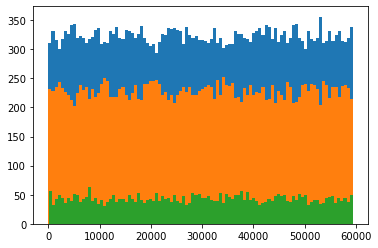

In [80]:
categories = train_label.status_group.unique()
for cat in categories:
    plt.hist( list( compress( range(len(train_label)) , (train_label.status_group==cat).values ) ) ,bins=100)

labels are evenly distributed.

In [81]:
train_label

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [82]:
train['data'] = "train"
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,data
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,train
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,train
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,train


In [83]:
#saving test_id for later use (in submission.csv)
test_id = test.id.values
test['data'] = "test"
test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,data
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,test
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,test
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,test
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,test
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,test
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,test
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,test
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,test


In [84]:
full = pd.concat([train , test] , axis=0)
del train , test
full

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,data
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,test
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,test
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,test
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,test




 id


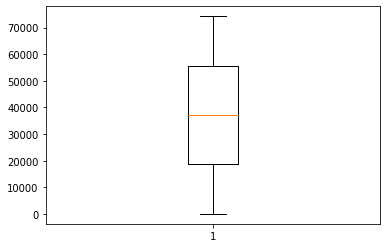



 amount_tsh


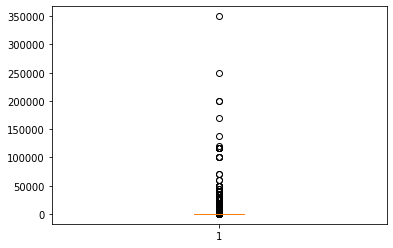



 gps_height


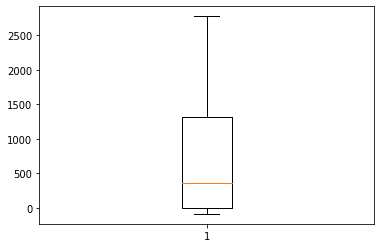



 longitude


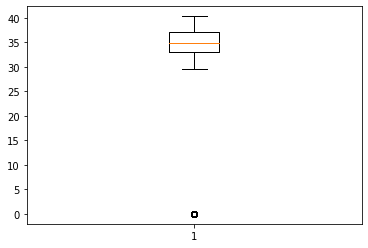



 latitude


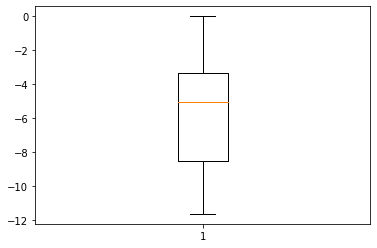



 num_private


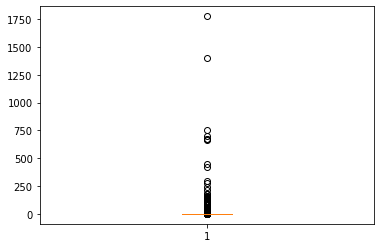



 region_code


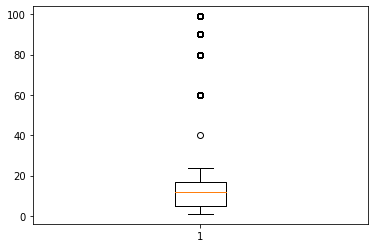



 district_code


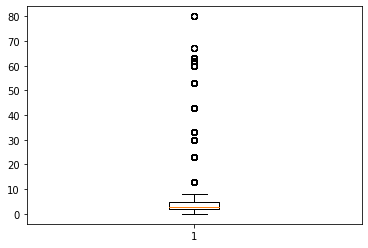



 population


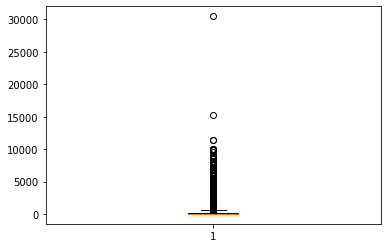



 construction_year


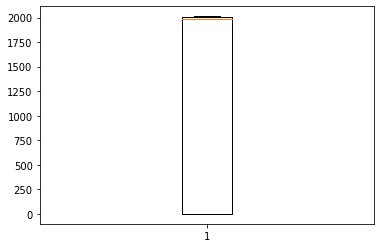

In [87]:
columns = full.columns
for col in columns:
    if(full[col].dtype=="int64" or full[col].dtype=="float64"):
        print("\n\n",col)
        plt.boxplot(full[col])
        plt.show()

In [88]:
for col in columns:
    print("\n\n",col,"\n",full[col].value_counts())



 id 
 2047     1
72310    1
14994    1
12947    1
2708     1
        ..
19811    1
30052    1
32101    1
25958    1
0        1
Name: id, Length: 74250, dtype: int64


 amount_tsh 
 0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
          ...  
5400.0        1
59.0          1
12.0          1
220.0         1
2550.0        1
Name: amount_tsh, Length: 102, dtype: int64


 date_recorded 
 2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-28      1
2011-09-13      1
2011-09-27      1
2004-12-03      1
2004-01-07      1
Name: date_recorded, Length: 369, dtype: int64


 funder 
 Government Of Tanzania        11299
Danida                         3907
Hesawa                         2782
Rwssp                          1703
World Bank                     1701
                              ...  
Wamissionari Wa Kikatoriki        1
John Skwese                       1
Mbuzi Mawe                       

 waterpoint_type_group 
 communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64


 data 
 train    59400
test     14850
Name: data, dtype: int64


### Feature Extraction

In [89]:
full['date_recorded'] = full['date_recorded'].astype('datetime64[ns]') 
for n in ('Year', 'Week', 'Day', 'Dayofweek'):
    full[n] = getattr(full.date_recorded.dt,n.lower())
full.drop(["date_recorded"],axis=1,inplace=True)
full.loc[full.Year<2011,"Year"] = 2011      

In [90]:
full['public_meeting'] = full['public_meeting'].fillna(True)
full['permit'] = full['permit'].fillna(True)

full['public_meeting'] = full['public_meeting'].astype(int)
full['permit'] = full['permit'].astype(int)

In [91]:
full['scheme_name_isnull'] = full.scheme_name.isnull().astype(int)
full['permit_isnull'] = full.permit.isnull().astype(int)

In [92]:
for col in ["scheme_name","subvillage","installer","funder"]:
    full[col] = full[col].fillna("not_present")

In [93]:
full['scheme_management'] = full['scheme_management'].fillna("VWC")
full['scheme_management'].replace({"NONE": "VMC"}, inplace = True)

In [94]:
for col in ["wpt_name","ward","lga","funder","installer","subvillage","scheme_name"]:
    y = full.groupby([col]).size().reset_index()
    y.columns = [col, col + '_Freq_En']
    full = pd.merge(full,y,on = col,how = 'left')

full['scheme_name_Freq_En'].replace({35258: 0}, inplace = True)

In [95]:
full.construction_year.replace({0: full[full.construction_year>0].construction_year.median()}, inplace = True)
full.region_code.replace({40:24 , 60:26 , 80:28 , 90:29 , 99:30}, inplace = True)

In [96]:
full.population = np.log10(full.population+1)
full.amount_tsh = np.log10(full.amount_tsh+1)

In [97]:
full.drop(["num_private","recorded_by","id"], axis=1, inplace=True)
full.drop(["wpt_name","ward","lga","funder","installer","subvillage","scheme_name"], axis=1, inplace=True)

In [98]:
icol = ["basin","region","region_code","district_code","scheme_management","extraction_type","extraction_type_group"
        ,"extraction_type_class","management","management_group","payment","payment_type","water_quality",
        "quality_group","quantity","quantity_group","source","source_type","source_class","waterpoint_type",
        "waterpoint_type_group","Year"]

full[pd.get_dummies(full[icol]).columns] = pd.get_dummies(full[icol])
full.drop(icol, axis=1, inplace=True)

In [99]:
# Checking DataType of columns
columns = full.drop(["data"],axis=1).columns
for col in columns:
    print(full[col].dtype)
full

float64
int64
float64
float64
float64
int64
int64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,data,Week,...,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,3.778224,1390,34.938093,-9.856322,2.041393,1,0,1999.0,train,11,...,0,0,0,0,0,1,0,0,0,0
1,0.000000,1399,34.698766,-2.147466,2.448706,1,1,2010.0,train,10,...,0,0,0,0,0,1,0,0,0,0
2,1.414973,686,37.460664,-3.821329,2.399674,1,1,2009.0,train,9,...,0,0,0,0,0,1,0,0,0,0
3,0.000000,263,38.486161,-11.155298,1.770852,1,1,1986.0,train,5,...,0,0,0,0,0,1,0,0,0,0
4,0.000000,0,31.130847,-1.825359,0.000000,1,1,2000.0,train,28,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,0.000000,34,38.852669,-6.582841,1.322219,1,1,1988.0,test,8,...,0,0,0,0,0,1,0,0,0,0
74246,3.000434,0,37.451633,-5.350428,3.471438,1,0,1994.0,test,12,...,0,1,0,0,0,0,0,1,0,0
74247,0.000000,1476,34.739804,-4.585587,2.303196,1,1,2010.0,test,10,...,0,0,0,0,0,1,0,0,0,0
74248,0.000000,998,35.432732,-10.584159,2.178977,1,1,2009.0,test,8,...,0,0,0,0,0,1,0,0,0,0


In [100]:
train = full[full.data=="train"].drop(["data"],axis=1)
test = full[full.data=="test"].drop(["data"],axis=1)
del full

In [101]:
X = normalize(train)
X_test = normalize(test)
le = preprocessing.LabelEncoder()
y = le.fit_transform(train_label.status_group.values)
del train , test , train_label

### LightGBM Classifier :-

In [103]:
folds = KFold(n_splits=3)
feature_importance_values = np.zeros(X.shape[1])
test_predictions = np.zeros((X_test.shape[0],3))

params = {'num_leaves': 256,
          'min_child_samples': 100,
          'max_depth': 13,
          'learning_rate': 0.03,
          "subsample_freq": 3,
          "subsample": 0.9,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9, 
          "early_stopping_rounds":100, 
          "n_estimators":1000}

for train_index, valid_index in folds.split(X):
    train_X, train_y = X[train_index] , y[train_index]
    valid_X, valid_y = X[valid_index] , y[valid_index]
    print("\n\n Fold starts\n")
    model = lgb.LGBMClassifier(**params , verbosity= -1 , objective="multiclass" , bagging_seed= 11 , n_jobs=-1, metric= 'multi_error' , boosting_type= "gbdt")
    model.fit( X=train_X,  y=train_y , eval_set = [(train_X, train_y),(valid_X, valid_y)] , eval_names = ['train', 'valid'], eval_metric='multi_logloss' , verbose=100)
    y_prob = model.predict_proba(X_test, num_iteration=model.best_iteration_)
    test_predictions = test_predictions + y_prob
    feature_importance_values = feature_importance_values + model.feature_importances_




 Fold starts



/Users/inder/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.511291	train's multi_error: 0.208106	valid's multi_logloss: 0.555938	valid's multi_error: 0.22798
[200]	train's multi_logloss: 0.450809	train's multi_error: 0.185404	valid's multi_logloss: 0.523079	valid's multi_error: 0.215455
[300]	train's multi_logloss: 0.415915	train's multi_error: 0.166364	valid's multi_logloss: 0.510181	valid's multi_error: 0.208586
[400]	train's multi_logloss: 0.386499	train's multi_error: 0.151035	valid's multi_logloss: 0.502671	valid's multi_error: 0.204444
[500]	train's multi_logloss: 0.362048	train's multi_error: 0.138131	valid's multi_logloss: 0.498681	valid's multi_error: 0.201364
[600]	train's multi_logloss: 0.341595	train's multi_error: 0.127652	valid's multi_logloss: 0.495524	valid's multi_error: 0.199394
[700]	train's multi_logloss: 0.320659	train's multi_error: 0.116263	valid's multi_logloss: 0.493776	valid's multi_error: 0.198535
[800]	train's multi_logloss: 

/Users/inder/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.506319	train's multi_error: 0.206793	valid's multi_logloss: 0.559374	valid's multi_error: 0.227121
[200]	train's multi_logloss: 0.446582	train's multi_error: 0.181894	valid's multi_logloss: 0.527784	valid's multi_error: 0.21596
[300]	train's multi_logloss: 0.410793	train's multi_error: 0.164141	valid's multi_logloss: 0.515395	valid's multi_error: 0.210253
[400]	train's multi_logloss: 0.382314	train's multi_error: 0.148434	valid's multi_logloss: 0.508704	valid's multi_error: 0.205303
[500]	train's multi_logloss: 0.358717	train's multi_error: 0.136944	valid's multi_logloss: 0.50474	valid's multi_error: 0.20303
[600]	train's multi_logloss: 0.33933	train's multi_error: 0.126667	valid's multi_logloss: 0.502717	valid's multi_error: 0.201515
[700]	train's multi_logloss: 0.320634	train's multi_error: 0.117424	valid's multi_logloss: 0.501667	valid's multi_error: 0.199949
[800]	train's multi_logloss: 0.3

/Users/inder/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.505508	train's multi_error: 0.205076	valid's multi_logloss: 0.554237	valid's multi_error: 0.224444
[200]	train's multi_logloss: 0.447412	train's multi_error: 0.181439	valid's multi_logloss: 0.525191	valid's multi_error: 0.212626
[300]	train's multi_logloss: 0.413581	train's multi_error: 0.164141	valid's multi_logloss: 0.51402	valid's multi_error: 0.207323
[400]	train's multi_logloss: 0.386912	train's multi_error: 0.152323	valid's multi_logloss: 0.507531	valid's multi_error: 0.206111
[500]	train's multi_logloss: 0.363245	train's multi_error: 0.139823	valid's multi_logloss: 0.503193	valid's multi_error: 0.204394
[600]	train's multi_logloss: 0.342909	train's multi_error: 0.128864	valid's multi_logloss: 0.500608	valid's multi_error: 0.201667
[700]	train's multi_logloss: 0.323612	train's multi_error: 0.117576	valid's multi_logloss: 0.499038	valid's multi_error: 0.201465
[800]	train's multi_logloss: 

Text(0.5, 1.0, 'LGB Features')

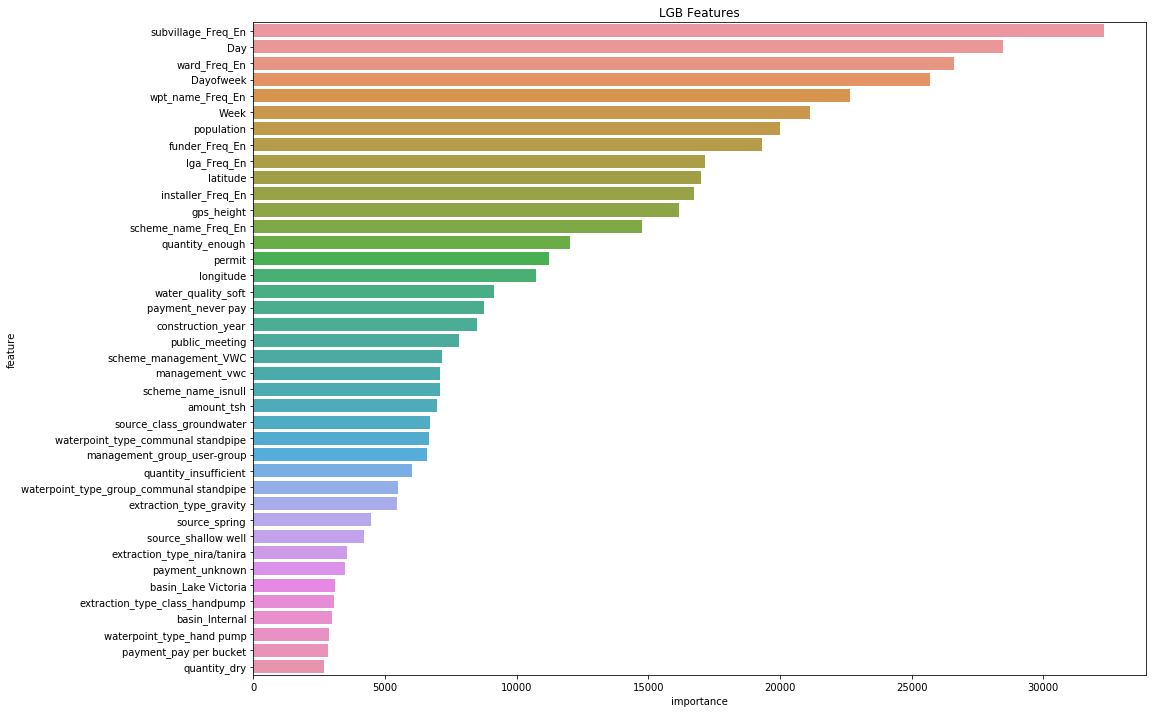

In [104]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = columns
feature_importance["importance"] = feature_importance_values
plt.figure(figsize=(16, 12))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False)[:40])
plt.title('LGB Features')

In [105]:
y_pred = np.argmax(test_predictions, axis=1)
yp=[]
for i in range(len(y_pred)):
    if(y_pred[i]==0):
        yp.append("functional")
    elif(y_pred[i]==1):
        yp.append("functional needs repair")
    else:
        yp.append("non functional")
sub = pd.DataFrame(index=None)
sub["id"] = test_id
sub["status_group"] = yp
sub.to_csv("/Users/inder/Downloads/sub.csv",index=False)